In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from model.model import SiameseNN
from model.config import config
from model.processing.data_management import load_data, prepare_data, prepare_dataloader, train_generator, test_generator
from model.score import get_test_accuracy, get_train_accuracy

Using TensorFlow backend.


In [2]:
data = load_data()

C:\Users\skyst\Documents\ProfessionalDevelopment\DataSciencePortfolio\facialRecognition\packages\model\model\data\subject*


In [3]:
train_images, train_labels, test_images, test_labels = prepare_data(data)

In [4]:
train_positives, train_negatives, test_positives, test_negatives = prepare_dataloader(train_images, train_labels, test_images, test_labels)

In [5]:
model = SiameseNN(config.FEATURE_DIM)

In [6]:
model.load_state_dict( state_dict = torch.load(config.TRAINED_MODEL_DIR / 'bestModel.pt') )

<All keys matched successfully>

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


428
13664
sensitivity (tpr): 1.0, specificity (tnr): 1.0


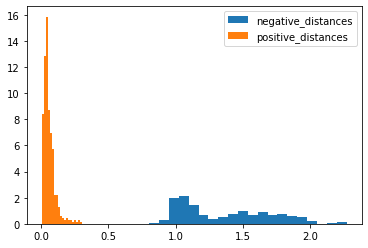

In [8]:
get_train_accuracy(model, train_images, train_positives, train_negatives, threshold=0.70)

45
1890
sensitivity (tpr): 0.9555555555555556, specificity (tnr): 0.973015873015873


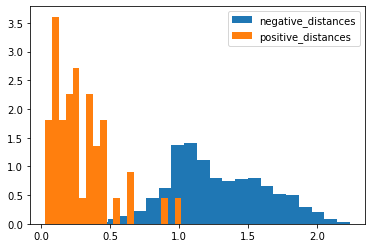

In [9]:
get_test_accuracy(model, test_images, test_positives, test_negatives, threshold=0.70)

# Facial Recognition (Work in progress)

In this project, I will be trying to determine if two grey-scale mugshot style photos are of the same person or not. To accomplish this, I will be training a Siamese network using a convolutional network architecture which ultimately resulted in a model with $95.5\%$ sensitivity and $97.3\%$ specificity.


## Data

The images I used to train this model were sourced from the "Yale Face Databse" which can be found at http://vision.ucsd.edu/content/yale-face-database. The data set contains 165 images of 15 individuals with 11 photos taken of each person. For each of the 11 photos under different lighting conditions, different facial expressions, and with or without glasses, etc.

Since we are focused on pairs of images, the size of our dataset is actually ${165}\choose{2}$  = 13530 of which 15${11}\choose{2} $ = 825 are positive matches. Therefore the data is largely unbalanced with only $6\%$ being a positive match. For this reason, I will report sensitivity and specificity rather than accuracy.   

## Training

I divided my training using roughly a 70/30 split. To ensure that each individual person had representation in the training and testing set, I designed the split to take 3 photos taken at random from each individual's set of photos.

After the split in my training set will contain have ${135}\choose{2} $ = 9045 pairs of which 15${8}\choose{2} $ = 420 are positive matches.

## References

1. This project started as a project in the Udemy course "Pytorch: Deep Learning and Artificial Intelligence", which I highly recommend.

2. The data can be found at http://vision.ucsd.edu/content/yale-face-database